# Big Data Bowl Special Teams Plays' Excitement Ratings

In this notebook, I'll try to create an excitement metric that will have a pre-snap prediction of "expected excitement", an in-play excitement meter, and an overall excitement score for each special teams play. 

## A Few Notes
- Pre snap excitement would probably just be some linear combination of game-level data
- In play excitement, could take tracking data along with game-level data in order to provide live adjustments to excitement
    - We'd need some way of storing excitement over time
- How is final excitement determined?
    - Is it just game level data again or can the in play tracking data affect the final score?

## Plan of Attack
1. Learn, clean, and manipulate the game, play, player, tracking, and scouting data
1. Split into test/train
1. Create a simple baseline metric to score each play in train data set
    1. This is probably just going to be game-level data
    1. We'll call this the overall excitement score
1. Train a model to predict overall excitement scores using only pre-snap (ie frame1) data
1. Use this model to predict excitement scores pre-snap on the test set
1. Analyze results to determine how good the model is
1. Create more complex excitement score based on player, team, game, play data
1. Rinse and repeat


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.animation import FuncAnimation

## Constants

In [2]:
field_height = 53.3
field_length = 120
endzone_length = 10

## Import and Inspect Game Data

In [3]:
games = pd.read_csv('data/games.csv')
games.head()

,gameId,season,week,gameDate,gameTimeEastern,homeTeamAbbr,visitorTeamAbbr
0,2018090600,2018,1,09/06/2018,20:20:00,PHI,ATL
1,2018090900,2018,1,09/09/2018,13:00:00,BAL,BUF
2,2018090901,2018,1,09/09/2018,13:00:00,CLE,PIT
3,2018090902,2018,1,09/09/2018,13:00:00,IND,CIN
4,2018090903,2018,1,09/09/2018,13:00:00,MIA,TEN


## Import and Inspect Player Data

In [4]:
players = pd.read_csv('data/players.csv')
players.head()

,nflId,height,weight,birthDate,collegeName,Position,displayName
0,42901,6-1,208,1992-07-25,James Madison,SS,Dean Marlowe
1,43501,6-0,220,1994-08-11,Central Michigan,FS,Kavon Frazier
2,43534,6-0,205,1993-06-02,Illinois,SS,Clayton Fejedelem
3,43535,6-1,235,1992-12-22,Temple,MLB,Tyler Matakevich
4,44174,6-1,236,1993-02-22,Texas Tech,ILB,Sam Eguavoen


## Import and Inspect Play Data

In [5]:
plays = pd.read_csv('data/plays.csv')
plays.head()

,gameId,playId,playDescription,quarter,down,yardsToGo,possessionTeam,specialTeamsPlayType,specialTeamsResult,kickerId,...,penaltyCodes,penaltyJerseyNumbers,penaltyYards,preSnapHomeScore,preSnapVisitorScore,passResult,kickLength,kickReturnYardage,playResult,absoluteYardlineNumber
0,2018090600,37,J.Elliott kicks 65 yards from PHI 35 to end zo...,1,0,0,PHI,Kickoff,Touchback,44966.0,...,NaN,NaN,NaN,0,0,NaN,66.0,NaN,40,45
1,2018090600,366,"(9:20) C.Johnston punts 56 yards to ATL 36, Ce...",1,4,4,PHI,Punt,Return,45603.0,...,UNSd,PHI 18,-15.0,0,0,NaN,56.0,5.0,36,18
2,2018090600,658,"(5:03) M.Bryant 21 yard field goal is GOOD, Ce...",1,4,3,ATL,Field Goal,Kick Attempt Good,27091.0,...,NaN,NaN,NaN,0,0,NaN,21.0,NaN,0,13
3,2018090600,677,M.Bosher kicks 64 yards from ATL 35 to PHI 1. ...,1,0,0,ATL,Kickoff,Return,37267.0,...,NaN,NaN,NaN,0,3,NaN,64.0,30.0,34,75
4,2018090600,872,"(:33) C.Johnston punts 65 yards to end zone, C...",1,4,18,PHI,Punt,Touchback,45603.0,...,NaN,NaN,NaN,0,3,NaN,65.0,NaN,45,45


## Import and Inspect Scouting Data

In [6]:
scout = pd.read_csv('data/PFFScoutingData.csv')
scout.head()


,gameId,playId,snapDetail,snapTime,operationTime,hangTime,kickType,kickDirectionIntended,kickDirectionActual,returnDirectionIntended,returnDirectionActual,missedTackler,assistTackler,tackler,kickoffReturnFormation,gunners,puntRushers,specialTeamsSafeties,vises,kickContactType
0,2018090600,37,NaN,NaN,NaN,3.85,D,R,R,NaN,NaN,NaN,NaN,NaN,8-0-2,NaN,NaN,PHI 23; PHI 27,NaN,NaN
1,2018090600,366,OK,0.84,2.12,4.46,N,C,C,C,R,PHI 57,NaN,PHI 54,NaN,PHI 18; PHI 29,NaN,NaN,ATL 83; ATL 27; ATL 34; ATL 21,CC
2,2018090600,658,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PHI 58,NaN,NaN
3,2018090600,677,NaN,NaN,NaN,4.06,D,R,R,C,C,ATL 83,ATL 22,ATL 27,8-0-2,NaN,NaN,ATL 17; ATL 22,NaN,NaN
4,2018090600,872,OK,0.84,2.00,4.35,N,C,L,NaN,NaN,NaN,NaN,NaN,NaN,PHI 18; PHI 29,ATL 85,ATL 37,ATL 83; ATL 34; ATL 21,BF


## Import and Inspect 2018 Tracking Data

In [7]:
tracking  = pd.read_csv('data/tracking2018.csv')
tracking.head()

,time,x,y,s,a,dis,o,dir,event,nflId,displayName,jerseyNumber,position,team,frameId,gameId,playId,playDirection
0,2018-12-30T21:25:32.200,41.32,29.45,4.36,1.33,0.43,130.42,128.44,None,39470.0,Justin Tucker,9.0,K,home,1,2018123000,36,right
1,2018-12-30T21:25:32.300,41.68,29.17,4.59,1.24,0.45,128.59,127.81,None,39470.0,Justin Tucker,9.0,K,home,2,2018123000,36,right
2,2018-12-30T21:25:32.400,42.05,28.88,4.74,0.99,0.47,124.47,128.15,None,39470.0,Justin Tucker,9.0,K,home,3,2018123000,36,right
3,2018-12-30T21:25:32.500,42.43,28.59,4.87,0.71,0.48,126.02,127.35,None,39470.0,Justin Tucker,9.0,K,home,4,2018123000,36,right
4,2018-12-30T21:25:32.600,42.84,28.31,4.96,0.79,0.50,131.71,124.75,None,39470.0,Justin Tucker,9.0,K,home,5,2018123000,36,right


## Enrich Tracking Data

In order to be consistent, let's standardize the play direction to always have the offense going from *left* to *right*. All we should need to do is for plays going to the *left*,
- flip x coordinate (`field_width - x`), 
- flip y coordinate (`field_height - y`), and 
- rotate the dir by 180 (`(360 - dir) % 360`). 

For plays going to the *right*, no conversion is needed. We'll store these new, or "standardized", values in `stdX`, `stdY`, and `stdDir`.

In [8]:
left_mask = tracking['playDirection'] == 'left'
right_mask = tracking['playDirection'] == 'right'
tracking.loc[left_mask, 'stdX'] = 120 - tracking.loc[left_mask, 'x']
tracking.loc[left_mask, 'stdY'] = field_height - tracking.loc[left_mask, 'y']
tracking.loc[left_mask, 'stdDir'] = (360 - tracking.loc[left_mask, 'dir']) % 360
tracking.loc[right_mask, 'stdX'] = tracking.loc[right_mask, 'x']
tracking.loc[right_mask, 'stdY'] = tracking.loc[right_mask, 'y']
tracking.loc[right_mask, 'stdDir'] = tracking.loc[right_mask, 'dir']
tracking.head()

,time,x,y,s,a,dis,o,dir,event,nflId,...,jerseyNumber,position,team,frameId,gameId,playId,playDirection,stdX,stdY,stdDir
0,2018-12-30T21:25:32.200,41.32,29.45,4.36,1.33,0.43,130.42,128.44,None,39470.0,...,9.0,K,home,1,2018123000,36,right,41.32,29.45,128.44
1,2018-12-30T21:25:32.300,41.68,29.17,4.59,1.24,0.45,128.59,127.81,None,39470.0,...,9.0,K,home,2,2018123000,36,right,41.68,29.17,127.81
2,2018-12-30T21:25:32.400,42.05,28.88,4.74,0.99,0.47,124.47,128.15,None,39470.0,...,9.0,K,home,3,2018123000,36,right,42.05,28.88,128.15
3,2018-12-30T21:25:32.500,42.43,28.59,4.87,0.71,0.48,126.02,127.35,None,39470.0,...,9.0,K,home,4,2018123000,36,right,42.43,28.59,127.35
4,2018-12-30T21:25:32.600,42.84,28.31,4.96,0.79,0.50,131.71,124.75,None,39470.0,...,9.0,K,home,5,2018123000,36,right,42.84,28.31,124.75


## Visualize Plays

One helpful thing when working with tracking data is to be able to see what each datapoint represents and how a frame looks. 
To do that, we'll create a function that creates a GIF of the requested play.
It'll take in a `game_id`, `play_id`, and Boolean flag `std` which says if the GIF should use the standardized coordinates or not. 

In [9]:
def animate_play(game_id, play_id, std=False):
    x_name = 'stdX' if std else 'x'
    y_name = 'stdY' if std else 'y'

    play = tracking.loc[(tracking['gameId'] == game_id) &( tracking['playId'] == play_id)]

    play['nflId'] = play['nflId'].fillna('football').astype(str)
    play['marker'] = play['team'].replace({'home': 'o', 'away': 's', 'football': 'd'})
    play['color'] = play['team'].replace({'home': 'r', 'away': 'blue', 'football': 'brown'})

    fig, ax = draw_field()
    markers = {
        f'{x["nflId"]}': ax.scatter(
            x[x_name], 
            x[y_name],
            s=10,
            marker=x['marker'],
            c=x['color'],
            zorder=3,
            edgecolors='black'
        ) for x in play.loc[play["frameId"] == 1].to_dict(orient='records')
    }

    def update(i):
        new_values = play.loc[play["frameId"] == i].set_index('nflId')[[x_name, y_name]].to_dict(orient='index')
        for k, v in markers.items():
            v.set_offsets([new_values[k][x_name], new_values[k][y_name]])
        return markers.values()

    ani = FuncAnimation(fig, update, frames=play['frameId'].unique(), blit=True)
    ani.save(f'game-{game_id}_play-{play_id}{"-std" if std else ""}.gif')

def draw_field():
    fig = plt.figure() 
    ax = plt.axes(xlim=(0, 120), ylim=(0, field_height)) 
    ax.set_facecolor('green')

    # Endzones
    rect = patches.Rectangle((0, 0), endzone_length, field_height, linewidth=1, edgecolor='r', facecolor='red', zorder=1)
    ax.add_patch(rect)
    rect = patches.Rectangle((field_length - endzone_length, 0), endzone_length, field_height, linewidth=1, edgecolor='blue', facecolor='blue', zorder=1)
    ax.add_patch(rect)

    # Yardlines
    for i in range(12):
        ax.plot((i*10, i*10), (0, field_height), color='w', zorder=1)
        if 1 < i < 11:
            label = (i-1) * 10
            ax.text(i*10 - 3, 5, f'{label}' if i < 6 else f'{100 - label}')

    plt.tick_params(
        axis='both', 
        which='both', 
        bottom=False, 
        top=False,       
        left=False,
        labelbottom=False,
        labelleft=False
    ) 
    return fig, ax


Let's try out this function with a play that's going to the *left* so we can see if the standardized coordinates worked as well. The first function call will create a file `game-2018090600_play-658-std.gif` and the second call will create `game-2018090600_play-658.gif`.

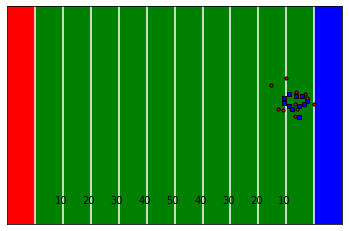

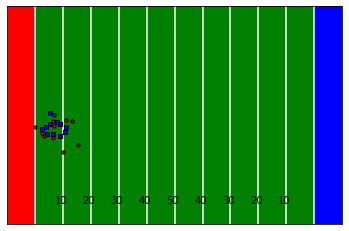

In [10]:
animate_play(2018090600, 658, True)
animate_play(2018090600, 658)

## Brain Dump on What Makes a Good Special Teams Play

> This is just some notes I didn't know where to put, but wanted to jot down
> 
>Something to keep in mind when considering excitement for plays is that you can't "pick a side", so defensive plays are as exciting as offensive plays. For example, if your punt got blocked, that's the opposite of exciting for you, but near-max excitement for the other team, which makes the play near-max exciting.

> It may also be interesting to try to have 3 different excitement metrics:
> - Home team
> - Away team
> - Game (this would probably just be the sum/max of home team and away team's excitement)

Before we consider specific types of special teams plays, there are some general attributes of any football game that contribute to excitement:
- Teams
    - Rivalries are exciting \[`is_rivalry`\]
    - Underdogs are exciting \[???\]
    - Game type (preseason, regular season, post season) are exciting \[`week`?\]
- Score of the game
    - Close games are exciting (usually more so for the underdog) \[`preSnapHomeScore`, `preSnapAwayScore`\]
    - Underdog wins are exciting \[???]\
    - Blowouts are generally less exciting \[scores again\]
    - Number of possessions in point differential are exciting (eg "if this field goal is good, it's a 1 posession game") \[scores and `specialTeamsPlayType`\]
- Time Left in the Game 
    - This usually is dependent on the score \[`gameClock`, `quarter`\]
    - Beginning of the game is almost always exciting \[`gameClock`, `quarter`\]
    - Overtime is exciting \[`quarter`\]
- The Unusual or Unexpected
    - Most of the time there is a clear "safe" option and a clear "risky" option. Risky is more exciting. \[`yardsToGo`, `score`, `yardLine`, `quarter`\]
    - Extreme plays are unusual (eg long field goals, long kickoff/punt returns, blocks, fumbles)
        - We'll discuss this more when we look at each type of play
    - Trick/Fake plays are exciting
    - Unusually long or short plays are exciting \[`numberOfFrames`, `operationTime`, `gameClock`\]
- Location of the Ball
    - Red zone possessions are exciting \[`yardline`\]
    - Pinning opponents in/close to their endzone is exciting \[`playResult`, `kickReturnYardage`\]

Now, with the above excitement factors in mind, let's break down each of the 4 types of Special Teams plays:

1. **Extra Point**
When are extra points exciting?
        
    - Generally 2 points are more exciting than 1
    - Longer or shorter than normal
    - A fake field goal
    - Good defensive play
        - Blocked PAT
        - Stopped 2pt conversion

1. **Field Goal**
When are field goals exciting?

    - Longer or shorter than normal
    - A fake
    - Fumble
    - Good defensive play
        - Block
        - Fumble recovery
        - Return on a fg

1. **Kickoff**
When is a kickoff exciting?

    - Long return
    - Botched/fumbled catch
    - Fair catches are not too exciting
    - When there is an onside kick
    - First play of the game/half/OT
    
1. **Punt**
When is a punt exciting?

    - Fake
    - Long/short punt
    - Leaves the defense inside 5/10
    - When it's a good defensive play
        - A block
        - A long return
        - A turnover on downs
    - Penalties that cause punting team to retain possesion

## Investigate Play Data to Try to Identify Exciting Plays

One main theme that appeared in theoretically exciting plays is unusual or unexpected plays. We'll try to find those by looking at outliers results of plays. To start, we'll count all the results for each special teams play types and then we'll analyze those results.

In [11]:
# How to heatmap df
# df.style.background_gradient(cmap='Blues')

In [12]:
num_games = plays['gameId'].unique().size

In [13]:
# To get an idea of the number of each play type per game
plays.groupby('specialTeamsPlayType').size().divide(num_games)

specialTeamsPlayType
Extra Point     4.565445
Field Goal      3.477749
Kickoff        10.265707
Punt            7.841623
dtype: float64

In [14]:
play_results = plays.groupby(['specialTeamsPlayType', 'specialTeamsResult']).size().unstack('specialTeamsPlayType')
play_results

specialTeamsPlayType,Extra Point,Field Goal,Kickoff,Punt
specialTeamsResult,,,,
Blocked Kick Attempt,24.0,37.0,NaN,NaN
Blocked Punt,NaN,NaN,NaN,39.0
Downed,NaN,1.0,4.0,829.0
Fair Catch,NaN,NaN,5.0,1640.0
Kick Attempt Good,3252.0,2218.0,NaN,NaN
Kick Attempt No Good,199.0,386.0,NaN,NaN
Kickoff Team Recovery,NaN,NaN,16.0,NaN
Muffed,NaN,NaN,60.0,154.0
Non-Special Teams Result,13.0,14.0,NaN,74.0


This data frame shows the number of times each result happens for each type of play for all the games in the dataset. We don't want to replace these NaN's with 0 because each play type only has a specific subset of the possible outcomes, so some outcomes cannot happen in certain scenarios. A 0 would indicate that outcome is possible, but it hasn't happened (which is important in our case because something that hasn't happened in 3 years would be very exciting).

Next, let's look at how many times each result happens per game.

In [15]:
play_results = play_results.divide(num_games)
play_results.style.background_gradient(cmap='Blues')

specialTeamsPlayType,Extra Point,Field Goal,Kickoff,Punt
specialTeamsResult,,,,
Blocked Kick Attempt,0.031414,0.048429,nan,nan
Blocked Punt,nan,nan,nan,0.051047
Downed,nan,0.001309,0.005236,1.085079
Fair Catch,nan,nan,0.006545,2.146597
Kick Attempt Good,4.256545,2.903141,nan,nan
Kick Attempt No Good,0.260471,0.505236,nan,nan
Kickoff Team Recovery,nan,nan,0.020942,nan
Muffed,nan,nan,0.078534,0.201571
Non-Special Teams Result,0.017016,0.018325,nan,0.096859


Another way of interpreting the above data frame is to consider its element-wise inverse, which shows how many games it takes for that outcome to happen.

In [16]:
play_results.pow(-1)

specialTeamsPlayType,Extra Point,Field Goal,Kickoff,Punt
specialTeamsResult,,,,
Blocked Kick Attempt,31.833333,20.648649,NaN,NaN
Blocked Punt,NaN,NaN,NaN,19.589744
Downed,NaN,764.000000,191.000000,0.921592
Fair Catch,NaN,NaN,152.800000,0.465854
Kick Attempt Good,0.234932,0.344454,NaN,NaN
Kick Attempt No Good,3.839196,1.979275,NaN,NaN
Kickoff Team Recovery,NaN,NaN,47.750000,NaN
Muffed,NaN,NaN,12.733333,4.961039
Non-Special Teams Result,58.769231,54.571429,NaN,10.324324


Selecting a few points from the previous data frames we can try to find some exciting scenarios:
- For a **Field Goal**, getting **Downed** or **Out of Bounds** is very uncommon and each outcome is expected to happen only once every 764 games!
- Getting a **Touchback** on a **Kick Off** is almost guaranteed to happen since you can expect around 6 **Touchbacks** per game

These two data frames can represent excitement based on how likely a play result is expected to happen. In the first frame,lower numbers represent less frequent outcomes, however in the latter, high numbers represent less frequent outcomes.

Another useful thing to understand is the distribution of outcomes for each play type. 

> *Note: pandas' pie plots out of the box aren't so great, but we can basically accomplish the same thing using bars.* 

So let's take a look:

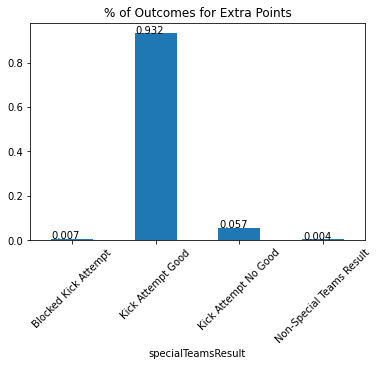

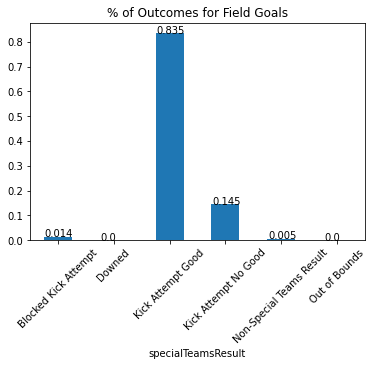

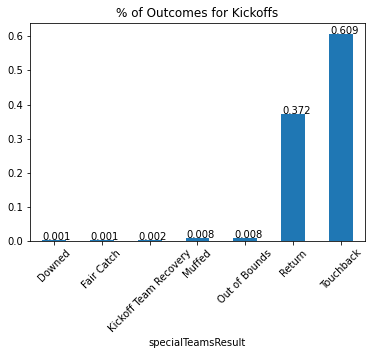

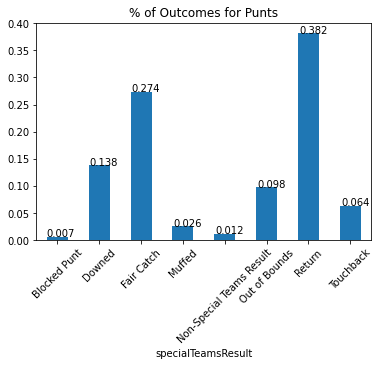

In [17]:
for play_type in play_results.columns:
    # Remove NA values and normalize each column before plotting it
    normalized_results = play_results[play_type].dropna().divide(play_results[play_type].sum())
    ax = normalized_results.plot.bar(title=f'% of Outcomes for {play_type}s', rot=45)
    
    # Label each bar
    for p in ax.patches:
        ax.annotate(str(round(p.get_height(), 3)), (p.get_x() * 1.005, p.get_height()))
    plt.show()

For the first, most basic, excitement metric, we'll rate the play only on how often the result happens for the play type. So the formula will be:

```excitement_score = 1 - p```

where `p` is the probability of that `specialTeamsResult` for the `specialTeamsPlayType`.

Let's add the `excitement_score_v1` to the plays df.

In [18]:
play_results_probs = play_results.div(play_results.sum(axis=0), axis=1)
play_results_probs

specialTeamsPlayType,Extra Point,Field Goal,Kickoff,Punt
specialTeamsResult,,,,
Blocked Kick Attempt,0.006881,0.013925,NaN,NaN
Blocked Punt,NaN,NaN,NaN,0.006510
Downed,NaN,0.000376,0.000510,0.138374
Fair Catch,NaN,NaN,0.000638,0.273744
Kick Attempt Good,0.932339,0.834776,NaN,NaN
Kick Attempt No Good,0.057053,0.145277,NaN,NaN
Kickoff Team Recovery,NaN,NaN,0.002040,NaN
Muffed,NaN,NaN,0.007650,0.025705
Non-Special Teams Result,0.003727,0.005269,NaN,0.012352


In [19]:
excitement_scores = play_results_probs.subtract(1).multiply(-1).unstack().dropna().rename('excitement_score_v1')
excitement_scores

specialTeamsPlayType  specialTeamsResult      
Extra Point           Blocked Kick Attempt        0.993119
                      Kick Attempt Good           0.067661
                      Kick Attempt No Good        0.942947
                      Non-Special Teams Result    0.996273
Field Goal            Blocked Kick Attempt        0.986075
                      Downed                      0.999624
                      Kick Attempt Good           0.165224
                      Kick Attempt No Good        0.854723
                      Non-Special Teams Result    0.994731
                      Out of Bounds               0.999624
Kickoff               Downed                      0.999490
                      Fair Catch                  0.999362
                      Kickoff Team Recovery       0.997960
                      Muffed                      0.992350
                      Out of Bounds               0.991840
                      Return                      0.627566
         

The above frame shows the excitement score for each possible outcome for each play type. Now we just have to add these scores to our `plays` data.

In [20]:
plays_v1 = plays.join(excitement_scores, on=['specialTeamsPlayType', 'specialTeamsResult'])
plays_v1

,gameId,playId,playDescription,quarter,down,yardsToGo,possessionTeam,specialTeamsPlayType,specialTeamsResult,kickerId,...,penaltyJerseyNumbers,penaltyYards,preSnapHomeScore,preSnapVisitorScore,passResult,kickLength,kickReturnYardage,playResult,absoluteYardlineNumber,excitement_score_v1
0,2018090600,37,J.Elliott kicks 65 yards from PHI 35 to end zo...,1,0,0,PHI,Kickoff,Touchback,44966.0,...,NaN,NaN,0,0,NaN,66.0,NaN,40,45,0.391432
1,2018090600,366,"(9:20) C.Johnston punts 56 yards to ATL 36, Ce...",1,4,4,PHI,Punt,Return,45603.0,...,PHI 18,-15.0,0,0,NaN,56.0,5.0,36,18,0.618428
2,2018090600,658,"(5:03) M.Bryant 21 yard field goal is GOOD, Ce...",1,4,3,ATL,Field Goal,Kick Attempt Good,27091.0,...,NaN,NaN,0,0,NaN,21.0,NaN,0,13,0.165224
3,2018090600,677,M.Bosher kicks 64 yards from ATL 35 to PHI 1. ...,1,0,0,ATL,Kickoff,Return,37267.0,...,NaN,NaN,0,3,NaN,64.0,30.0,34,75,0.627566
4,2018090600,872,"(:33) C.Johnston punts 65 yards to end zone, C...",1,4,18,PHI,Punt,Touchback,45603.0,...,NaN,NaN,0,3,NaN,65.0,NaN,45,45,0.936071
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19974,2021010315,3683,J.Myers kicks 65 yards from SEA 35 to end zone...,4,0,0,SEA,Kickoff,Touchback,41175.0,...,NaN,NaN,16,19,NaN,75.0,NaN,40,75,0.391432
19975,2021010315,3870,"J.Myers extra point is GOOD, Center-T.Ott, Hol...",4,0,0,SEA,Extra Point,Kick Attempt Good,41175.0,...,NaN,NaN,16,25,NaN,NaN,NaN,0,25,0.067661
19976,2021010315,3886,J.Myers kicks 65 yards from SEA 35 to end zone...,4,0,0,SEA,Kickoff,Touchback,41175.0,...,NaN,NaN,16,26,NaN,75.0,NaN,40,75,0.391432
19977,2021010315,4166,"T.Vizcaino extra point is GOOD, Center-C.Holba...",4,0,0,SF,Extra Point,Kick Attempt Good,47590.0,...,NaN,NaN,22,26,NaN,NaN,NaN,0,95,0.067661
